# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


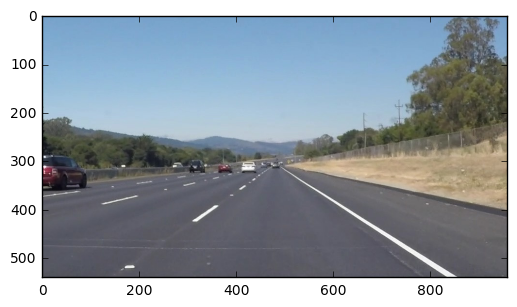

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image);  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [103]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color(white)    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_single_line(img, lines, y_min, y_max, color, thickness):
    points = []
    total_slope = 0
    total_y_intercept = 0
    n = len(lines)
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1)/(x2 - x1)
            total_slope += slope
            total_y_intercept += (y1 - slope * x1)
    
    average_slope = total_slope/n
    average_y_intercept = total_y_intercept/n
    
    x1 = int((y_min - average_y_intercept)/average_slope)
    x2 = int((y_max - average_y_intercept)/average_slope)
    
    cv2.line(img, (x1, y_min), (x2, y_max), color, thickness)


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Find the global y_min
    y_min_point1 = min(lines, key=lambda x: x[0][1])
    y_min_point2 = min(lines, key=lambda x: x[0][3])
    y_min = min(y_min_point1[0][1], y_min_point2[0][3])
    
    y_max = img.shape[0]

    positive_slopes = list(filter(lambda line: ((line[0][3]-line[0][1])/(line[0][2]-line[0][0])) > 0.2, lines))
    negative_slopes = list(filter(lambda line: ((line[0][3]-line[0][1])/(line[0][2]-line[0][0])) < -0.2, lines))
    draw_single_line(img, positive_slopes, y_min, y_max, color, thickness)
    draw_single_line(img, negative_slopes, y_min, y_max, color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines, thickness=5)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def get_blank_image(image):
    """
        Return a blank image with the same dimensions as
        the input image
    """
    return np.zeros(image.shape, dtype=np.uint8)

def perform_color_selection(img):
    img[img[:] < 70] = 0
    return img

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [104]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

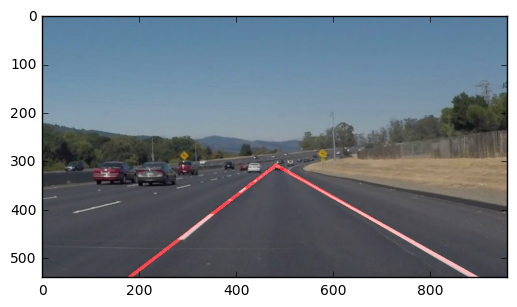

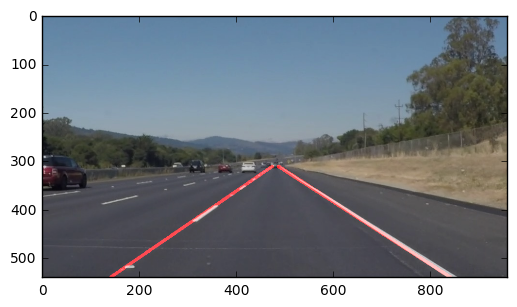

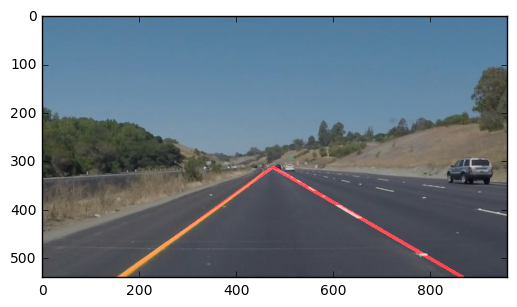

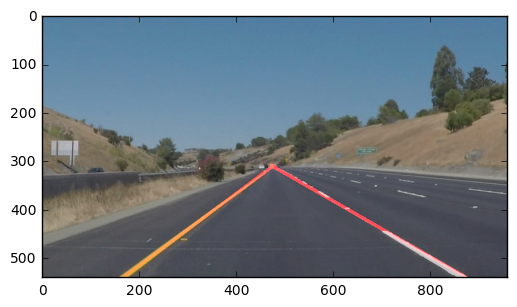

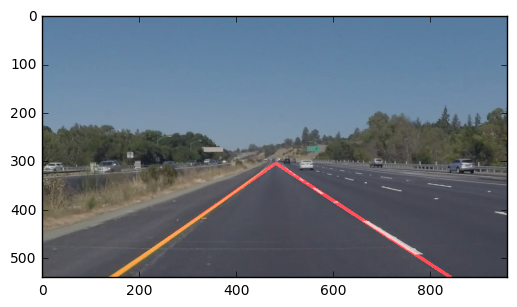

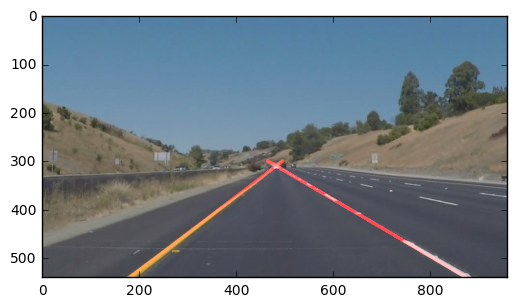

In [106]:
# Hough transform parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 # minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

gaussian_kernel_size = 5

canny_low_threshold = 50
canny_high_threshold = 150

region_of_interest_vertices = np.array([[(-5,600),(500, 300), (950, 600)]], dtype=np.int32)
                                       
def get_lane_markings(image):
    gray_img = grayscale(image)
    blurred_gray_img = gaussian_blur(gray_img, kernel_size=gaussian_kernel_size)
    blurred_gray_img = perform_color_selection(blurred_gray_img)
    egdes_img = canny(blurred_gray_img, low_threshold=canny_low_threshold, high_threshold=canny_high_threshold)
    region_interest_img = region_of_interest(egdes_img,region_of_interest_vertices)
    lines_image = hough_lines(region_interest_img, rho=rho, theta=theta, threshold=threshold, min_line_len=min_line_length, max_line_gap=max_line_gap)
    colored_lines_image = np.dstack((lines_image, get_blank_image(lines_image), get_blank_image(lines_image)))
    return weighted_img(colored_lines_image, image)
    
for image_name in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + image_name)
    processedImage = get_lane_markings(image)
    plt.imshow(processedImage);
    plt.show();

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [107]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [108]:
def process_image(image):
    return get_lane_markings(image)

Let's try the one with the solid white lane on the right first ...

In [109]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 67.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.9 s, sys: 606 ms, total: 3.51 s
Wall time: 3.73 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [110]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [86]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:10<00:00, 63.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.03 s, sys: 2.23 s, total: 11.3 s
Wall time: 11.1 s


In [87]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

- I've named the method that forms the pipeline `get_lane_markings`
- It does the following operations
    1. Coverts the image to grayscale
    2. Applies a Gaussian filter to the output of 1.
    3. Removes dark pixels by performing color selection on the output of 2.
    4. Applies the canny filter to the output of 3.
    5. Gets the region of interest from the output of 4.
    6. Draws hough lines on the output of 5.
    7. Creates a 3 color version of 6.
    8. Combines the hough lines with the original image
- To get a single line for the dashed left/right lane line:
    1. Divide all hough lines into two groups: lines with positive slopes and lines with negative slopes
    2. Use the openCV `polylines` function to draw a curve separately through the points of group 1 and group 2.
   
- I'm not particularly happy with the output in the case of the yellow lane line as it sometimes has cross lines during turns
- Also, this solution does not work for the shadow challenge below.

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [92]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

0.652465297262 9.78697945893 -7.11848047896 -106.777207184 15
-0.662714621126 -10.603433938 857.774209586 13724.3873534 16
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4



  2%|▏         | 4/251 [00:00<00:06, 37.45it/s]

0.652465297262 9.78697945893 -7.11848047896 -106.777207184 15
-0.662714621126 -10.603433938 857.774209586 13724.3873534 16
0.683103939562 6.83103939562 -38.7306229069 -387.306229069 10
-0.7210835461 -12.9795038298 871.588818141 15688.5987265 18
0.65020007758 12.353801474 0.0441263243889 0.838400163389 19
-0.76091709652 -5.32641967564 911.314141713 6379.19899199 7
0.660826429274 13.8773550148 -15.4265439641 -323.957423246 21
-0.773714731019 -12.3794356963 919.98441081 14719.750573 16
0.827131799485 11.5798451928 -122.118076943 -1709.65307721 14
-0.675024159902 -9.45033823863 857.822102502 12009.509435 14
0.798424908168 15.9684981634 -86.8602952461 -1737.20590492 20
-0.69984181724 -9.09794362411 882.255696503 11469.3240545 13
0.741440714325 14.8288142865 -68.1336882132 -1362.67376426 20
-0.68279959419 -10.924793507 872.482544063 13959.720705 16
0.675436489026 14.1841662695 -15.3125538637 -321.563631137 21
-0.68442111611 -7.52863227721 872.963685384 9602.60053923 11


0.676952887018 14.2160106274 -19.9634057669 -419.231521105 21
-0.678943848829 -8.14732618595 869.12020905 10429.4425086 12



  5%|▌         | 13/251 [00:00<00:06, 38.39it/s]

0.63823686489 8.93531610846 -2.84276991448 -39.7987788027 14
-0.686840764608 -6.86840764608 853.195225614 8531.95225614 10
0.703176176875 10.5476426531 -36.7387142132 -551.080713198 15
-0.630720244832 -4.41504171382 840.058997965 5880.41298575 7
0.66709388868 11.3405961076 -17.8847041868 -304.039971176 17
-0.662078387341 -4.63454871139 836.245493865 5853.71845706 7
0.70126058179 12.6226904722 -18.3747416053 -330.745348895 18
-0.685019177708 -4.11011506625 871.586710341 5229.52026205 6
0.818627074113 16.3725414823 -92.2399193954 -1844.79838791 20
-0.717048439787 -5.73638751829 888.394009226 7107.15207381 8
0.660585814003 11.8905446521 -6.88241228028 -123.883421045 18
-0.669412677153 -4.68588874007 860.250183689 6021.75128582 7
0.665703506383 16.6425876596 -13.6029083451 -340.072708628 25
-0.712558656461 -6.41302790815 871.908533982 7847.17680584 9



  7%|▋         | 17/251 [00:00<00:06, 37.95it/s]

0.726693930103 22.5275118332 -37.5514223916 -1164.09409414 31
-0.687314627115 -6.87314627115 869.27075988 8692.7075988 10



  8%|▊         | 20/251 [00:00<00:06, 34.84it/s]

0.735434044989 26.4756256196 -41.0461536678 -1477.66153204 36
-0.717292780895 -5.02104946626 886.150950564 6203.05665395 7
0.673065422551 23.5572897893 -14.023274453 -490.814605853 35
-0.735190465366 -6.61671418829 873.122222025 7858.09999823 9
0.692810770999 19.398701588 -22.860745736 -640.100880608 28
-0.722006670885 -4.33204002531 889.305444154 5335.83266493 6
0.637331995411 15.2959678899 -4.64907795844 -111.577871003 24
-0.695646080393 -4.17387648236 841.366560691 5048.19936415 6
0.682597978623 18.4301454228 -20.7897726363 -561.323861179 27
-0.6847996398 -6.1631967582 828.300667161 7454.70600445 9
0.808679383456 30.7298165713 -79.9757038714 -3039.07674711 38
-0.646545494367 -5.8189094493 828.717408236 7458.45667413 9



 10%|▉         | 24/251 [00:00<00:06, 35.70it/s]

0.667856466891 26.0464022088 -8.84529343425 -344.966443936 39
-0.680948867048 -6.12853980343 865.57616875 7790.18551875 9



 11%|█         | 28/251 [00:00<00:06, 33.72it/s]

0.790697021124 24.5116076548 -75.9637072479 -2354.87492468 31
-0.745703555819 -10.4398497815 921.469661281 12900.5752579 14
0.751595200762 18.789880019 -50.2059233063 -1255.14808266 25
-0.7043310538 -4.9303173766 853.72321829 5976.06252803 7
0.761720382434 28.9453745325 -63.3837321857 -2408.58182305 38
-0.691160298212 -6.91160298212 835.48677384 8354.8677384 10
0.847569963819 27.969808806 -100.4415032 -3314.56960559 33
-2.09346309956 -23.0280940952 1804.24791827 19846.7271009 11
0.758878994883 31.8729177851 -59.4274023692 -2495.95089951 42
-0.788542019163 -11.0395882683 903.591973578 12650.2876301 14
0.827607632332 41.3803816166 -91.9426902132 -4597.13451066 50


-0.727382568714 -8.72859082457 896.499555258 10757.9946631 12
0.81253972586 43.8771451965 -67.8108739937 -3661.78719566 54
-0.735118448963 -8.08630293859 904.126888976 9945.39577874 11



 14%|█▍        | 36/251 [00:01<00:06, 32.95it/s]

0.896257363546 39.435323996 -132.408849933 -5825.98939705 44
-0.76194942469 -10.6672919457 884.096456382 12377.3503894 14
0.930912317021 46.5456158511 -151.822107719 -7591.10538595 50
-0.75606246876 -12.8530619689 867.307121726 14744.2210693 17
0.839773352728 47.8670811055 -92.7916747667 -5289.1254617 57
-0.730279790694 -11.6844766511 859.480430846 13751.6868935 16
0.754829128989 40.0059438364 -43.6764953182 -2314.85425186 53
-0.618592412336 -9.89747859737 785.953266978 12575.2522716 16
0.761046001555 49.4679901011 -44.1503454237 -2869.77245254 65
-0.673569842701 -12.7978270113 855.287394628 16250.4604979 19
0.771865737901 57.1180646047 -46.9808515563 -3476.58301517 74
-0.645027593488 -10.3204414958 839.116900895 13425.8704143 16
0.799139442891 57.5380398882 -53.330687002 -3839.80946415 72
-0.637202141286 -13.381244967 812.747799845 17067.7037968 21



 16%|█▌        | 40/251 [00:01<00:06, 32.76it/s]

0.741505502342 44.4903301405 -35.1371242866 -2108.2274572 60
-0.667213495919 -11.3426294306 837.814329745 14242.8436057 17
0.835300262582 50.9533160175 -80.1469249133 -4888.96241971 61
-0.66394241479 -12.614905881 840.155256 15962.949864 19
0.721162048167 41.8273987937 -26.9131205901 -1560.96099423 58
-0.675717413494 -9.46004378891 838.233154135 11735.2641579 14
1.15077033342 81.7046936725 -281.255869301 -19969.1667203 71
-0.676856450075 -11.5065596513 868.262433709 14760.461373 17
0.874351177855 50.7123683156 -104.236215025 -6045.70047145 58
-0.725970503809 -10.8895575571 913.112803806 13696.6920571 15



 18%|█▊        | 44/251 [00:01<00:06, 31.25it/s]

0.826742487712 58.6987166275 -78.7381339095 -5590.40750757 71
-0.741996351652 -11.1299452748 875.368657597 13130.529864 15



 19%|█▉        | 48/251 [00:01<00:06, 29.18it/s]

0.848932121634 64.5188412442 -81.6578261849 -6205.99479005 76
-0.692815676918 -10.3922351538 880.947941186 13214.2191178 15
0.898315979562 61.9838025898 -105.607023548 -7286.88462481 69
-0.85947359811 -10.3136831773 996.620724875 11959.4486985 12
0.849059062032 60.2831934043 -80.5534088268 -5719.2920267 71
-1.24642249856 -16.2034924813 1154.625931 15010.137103 13
0.689370786821 46.187842717 3.13514611101 210.054789438 67
-0.663711250477 -6.63711250477 860.16546021 8601.6546021 10
0.836254587785 49.3390206793 -68.5025919635 -4041.65292585 59
-inf -inf inf inf 10


ValueError: cannot convert float NaN to integer

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">git
</video>
""".format(challenge_output))